## Advanced Lane Finding Project

This project involves the following steps:

1. Compute the camera calibration matrix and distortion coefficients given a set of chessboard images.
2. Apply a distortion correction to raw images.
3. Use color transforms, gradients, etc., to create a thresholded binary image.
4. Apply a perspective transform to rectify binary image ("birds-eye view").
5. Detect lane pixels and fit to find the lane boundary.
6. Determine the curvature of the lane and vehicle position with respect to center.
7. Warp the detected lane boundaries back onto the original image and show estimate of lane curvature and vehicle position.
8. Run project videos of a car driving down the freeway through the image processing pipeline.

## 1. Camera Calibration

**Source code:** calibrate_camera.py, distortion.py

Camera calibration is done by loading the calibration images at __camera_cal/calibrate*.jpg__ and running grayscale versions through _cv2.findChessboardCorners()_. Corners are drawn on these images using _cv2.drawChessboardCorners()_ and saved as output to __camera_cal/corners*.jpg__.  *objpoints* and *imgpoints* arrays are passed to _cv2.calibrateCamera()_ which returns the distortion coefficients and matrix needed to undistort the image.  Distortion matrix and coefficients are stored in a pickle file so that they can be re-used throughout the project to undistort images. This is done by instantiating a __Distortion__ object from the the pickle file and calling __undistort()__ which uses _cv2.undistort()_ to undistort the image. An example set of camera calibration chessboard images that have been undistorted by loading the Distortion object and calling __undistort()__ is shown below. A full set of undistorted camera calibration images are saved at __camera_cal/undistort*.jpg__ 

In [ ]:
# Calibrate camera and undistort example chessboard images
import cv2
import glob
import matplotlib.pyplot as plt
from image_helper import rgb_image, sorter
from calibrate_camera import calibrate_camera
from distortion import Distortion

calibrate_camera()

# Load calibration from pickle
distortion = Distortion("./camera_cal/wide_dist_pickle.p")

# Make a list of calibration images
images = sorted(glob.glob('./camera_cal/calibration*.jpg'))

for i, filepath in enumerate(images[:5]):    
    img = rgb_image(filepath)

    undt = distortion.undistort(img)
    
    plt.imsave("./camera_cal/undistort{:02d}.jpg" .format(i+1), undt)
    
    f, (ax1, ax2) = plt.subplots(1, 2, figsize=(13, 10))
    f.tight_layout()

    ax1.set_title("Original image: " +filepath)
    ax1.imshow(img)
    
    ax2.set_title("Undistorted image")
    ax2.imshow(undt)

    plt.show()

## 2. Undistort test images

**Source code:** distortion.py

Here are examples of all __test_images/*.jpg__ undistorted by loading the Distortion class object and calling __undistort()__ method against each test image. Distortion class loads the camera calibration matrix and distortion coefficients from the pickle file as explained above.

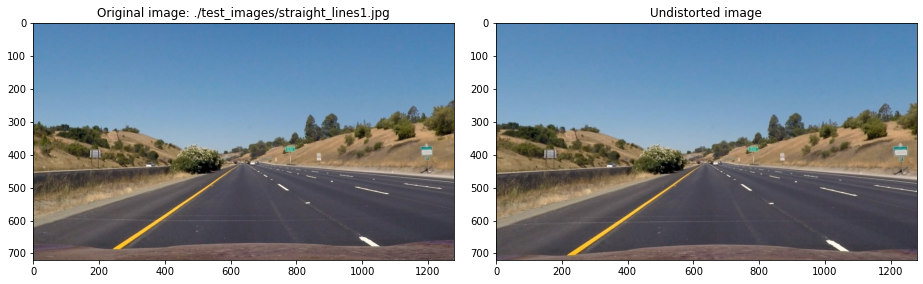

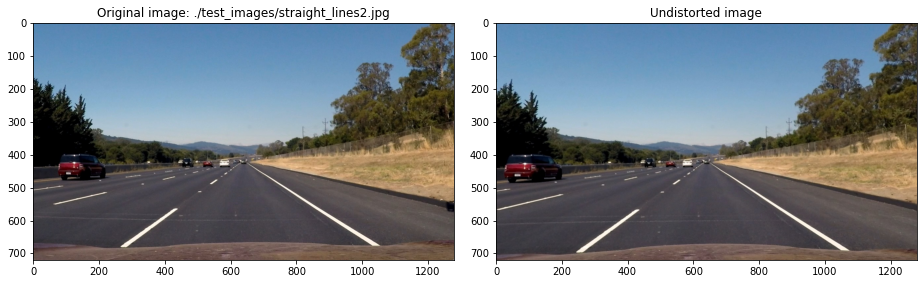

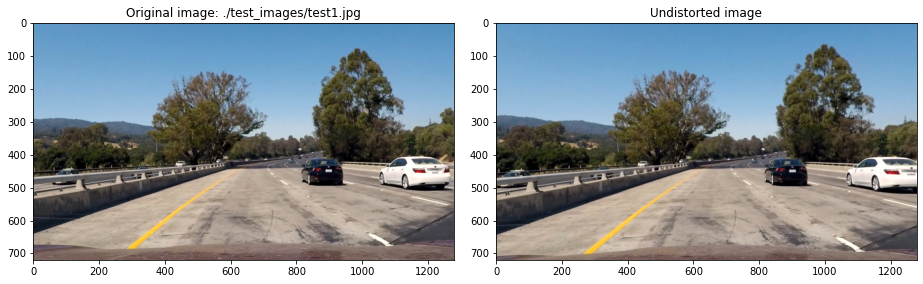

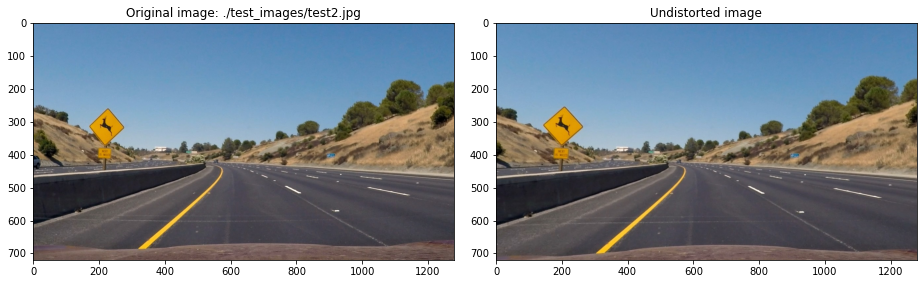

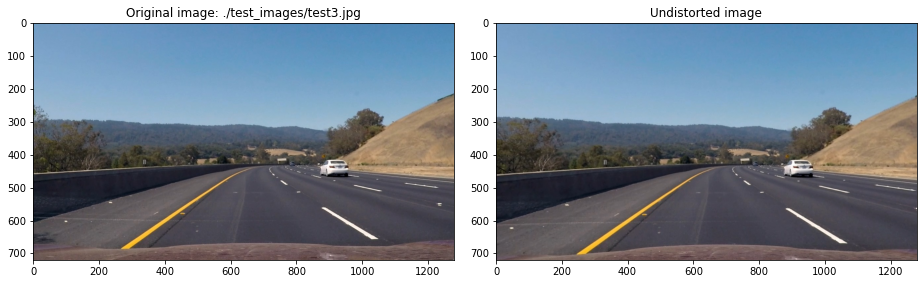

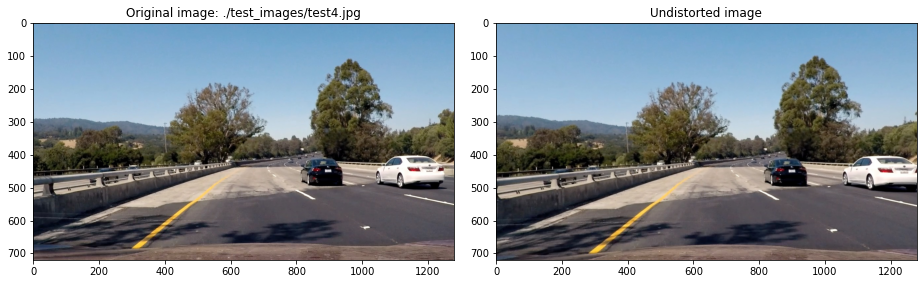

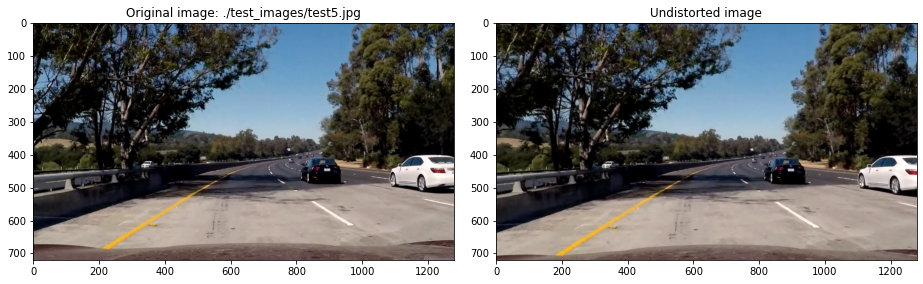

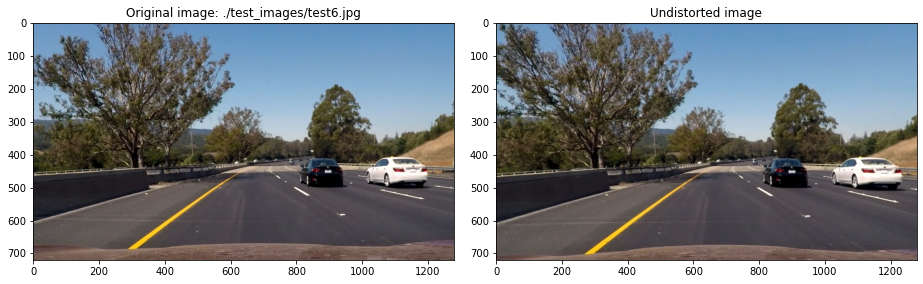

In [7]:
# Undistort test images
import cv2
import glob
import matplotlib.pyplot as plt
from image_helper import rgb_image, sorter
from distortion import Distortion

distortion = Distortion("./camera_cal/wide_dist_pickle.p")

images = sorted(glob.glob('./test_images/*.jpg'))

for i, filepath in enumerate(images[:]):
    img = rgb_image(filepath)
    undt = distortion.undistort(img)
    
    plt.imsave("./output_images/undistort_{:02d}.jpg" .format(i), undt)
    
    f, (ax1, ax2) = plt.subplots(1, 2, figsize=(13, 10))
    f.tight_layout()

    ax1.set_title("Original image: "+filepath)
    ax1.imshow(img)

    ax2.set_title("Undistorted image")
    ax2.imshow(undt)

    plt.show()

## 3. Gradient and Colour threshold transformations

__Source code:__ combined_thresholds.py

This code applies multiple gradient and thresholding transformations to images.  

__Sobel gradient thesholding in X and Y directions__  
Sobel gradient thresholding was used to detect changes in pixel density in the horizontal and vertical directions. 

__Sobel gradient magnitude thresholding__  
This was not used in the submitted version as it did not offer any additional clarity over X and Y gradient thresholding.

__Sobel gradient direction thresholding__  
This was not used in the submitted version as it seemed to add a lot of additional noise in the image background.

__HLS - Saturation channel thresholding__  
After converting the RGB image to the HLS colorspace, the Saturation channel is good at detecting yellow lines.  

__RGB - Red channel thresholding__  
The red channel of the RGB image in BGR channel order is good at detecting white lines.  

After experimenting with values and different combinations, the thresholding techniques were combined using OR operators on __Grad-X, Grad-Y, Saturation__ and __Red channel__ transforms. Example results are shown below.


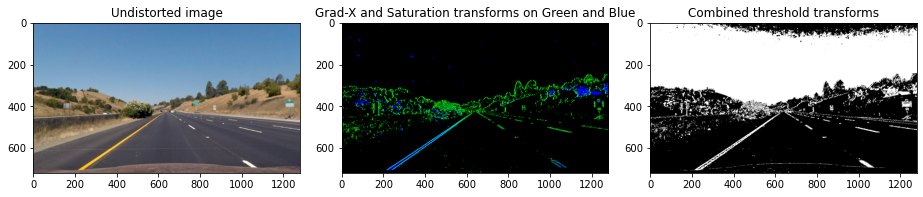

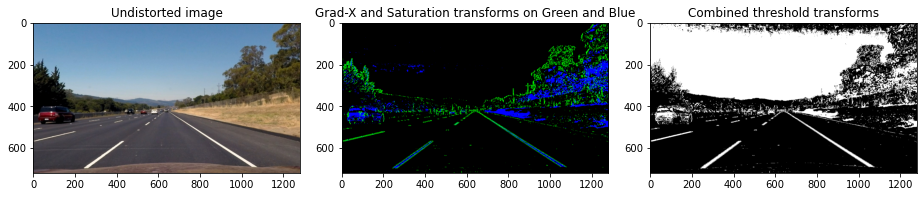

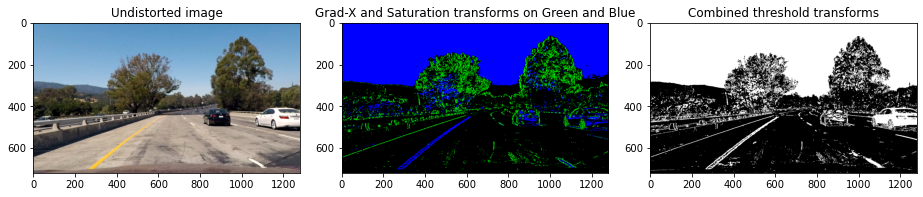

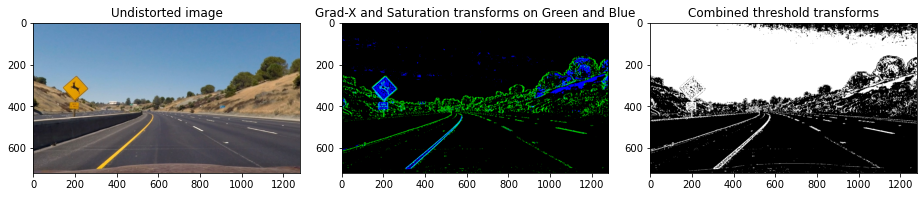

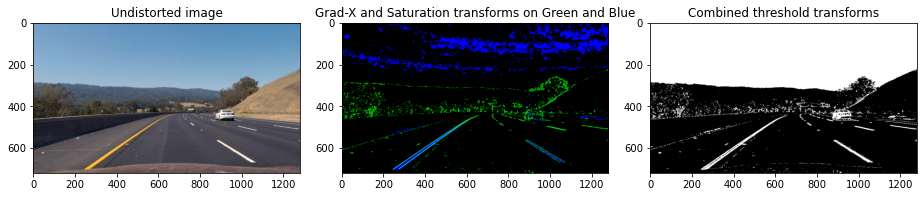

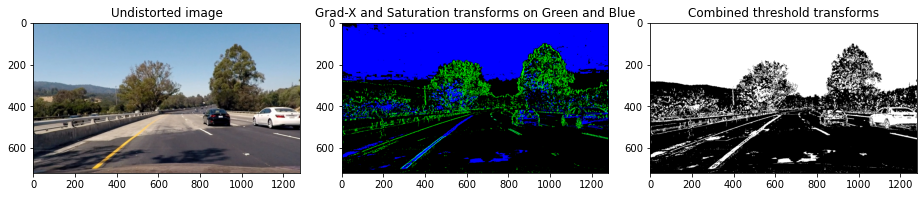

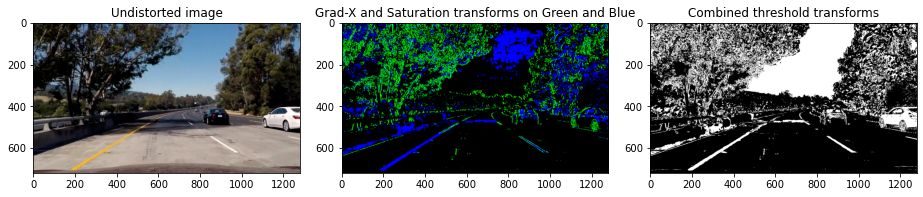

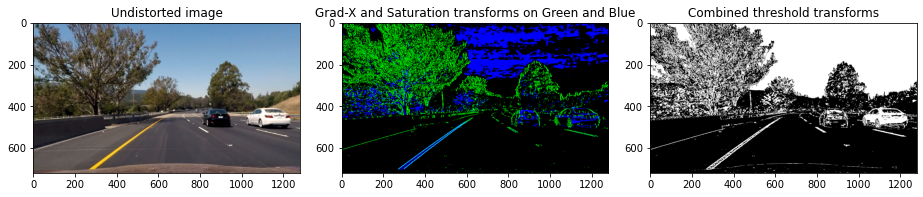

In [6]:
# Transform undistorted images via thresholding combinations
import cv2
import glob
import matplotlib.pyplot as plt
from image_helper import rgb_image, bgr_to_rgb, sorter
from distortion import Distortion
import combined_thresholds

distortion = Distortion("./camera_cal/wide_dist_pickle.p")

images = sorted(glob.glob('./test_images/*.jpg'))

for i, filepath in enumerate(images[:]):
    img = cv2.imread(filepath)
    
    undt = distortion.undistort(img)
    thr, gb = combined_thresholds.pipeline(undt)
    
    plt.imsave("./output_images/undistorted_{:02d}.jpg" .format(i), bgr_to_rgb(undt))
    plt.imsave("./output_images/threshold_{:02d}.jpg" .format(i), thr, cmap='gray')
    
    f, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(13, 10))
    f.tight_layout()

    ax1.set_title("Undistorted image")
    ax1.imshow(bgr_to_rgb(undt))
    
    ax2.set_title("Grad-X and Saturation transforms on Green and Blue")
    ax2.imshow(gb)

    ax3.set_title("Combined threshold transforms")
    ax3.imshow(thr, cmap='gray')

    plt.show()

## 4. Perspective transformation

__Source code:__ birdseye.py

This code instantiates a BirdsEyeView object with methods **transform_to_birdseye()** and **transform_from_birdseye()** that transform the perspective of any image to or from birds-eye view by using _cv2.warpPerspective()_.  These perspective transforms use **transform_matrix()** and **inverse_transform_matrix()** methods created from a manually-defined set of source and destination polygon points and then using _cv2.getPerspectiveTransform()_ to define the actual tranformation in each direction. The source and destination points were defined by visually inspecting the initial straight line view of the road __./test_images/straight_lines1.jpg__ (which has a known perspective) and seeking to find source and destination points that transform it to a top-down view with nearly straight parallel lines. The results below show test_images transformed to birds-eye view using **birdseye.py** and then transformed using **combined_thresholds.py**.


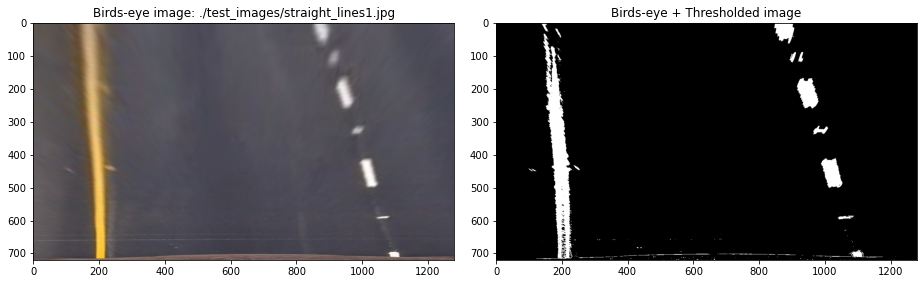

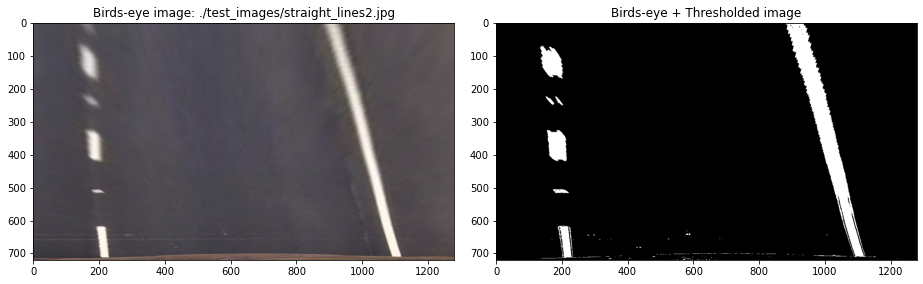

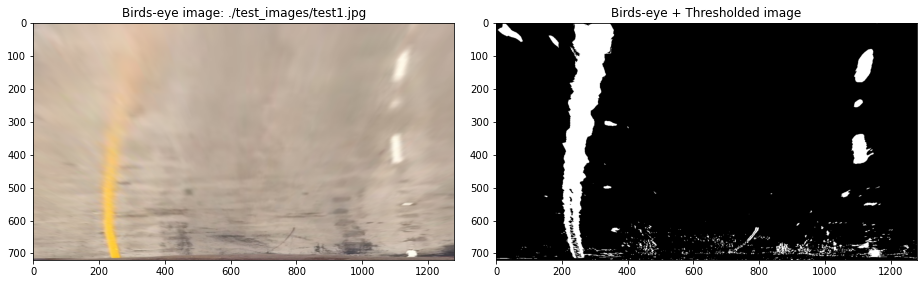

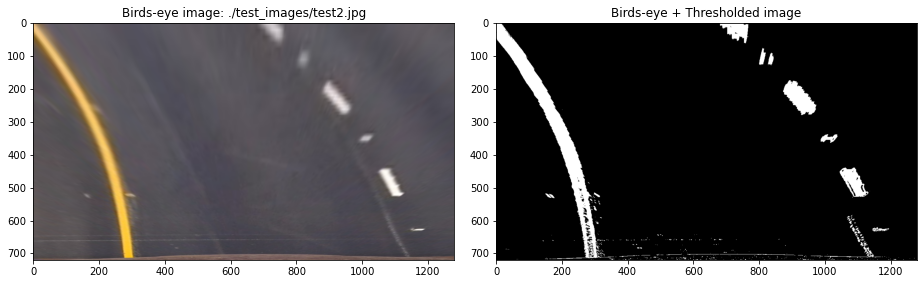

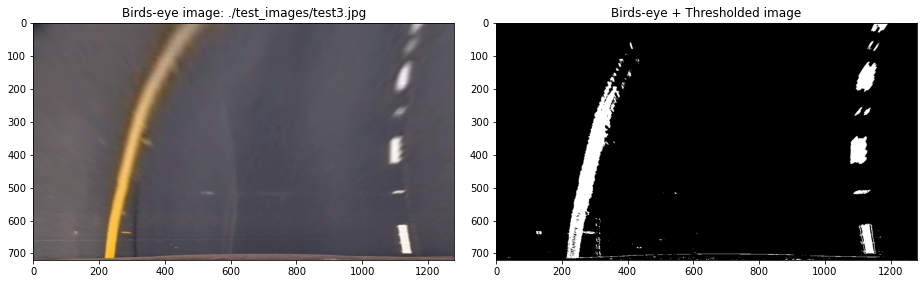

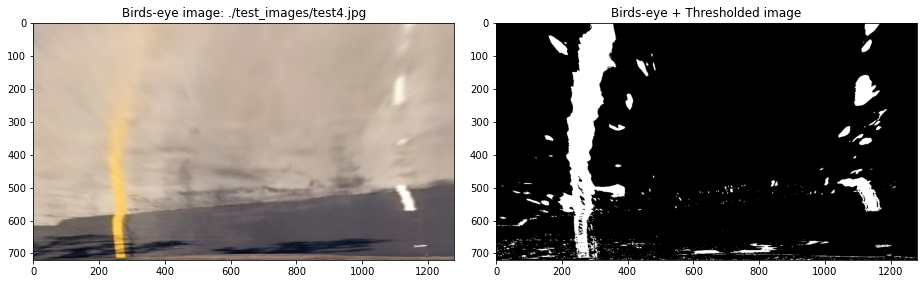

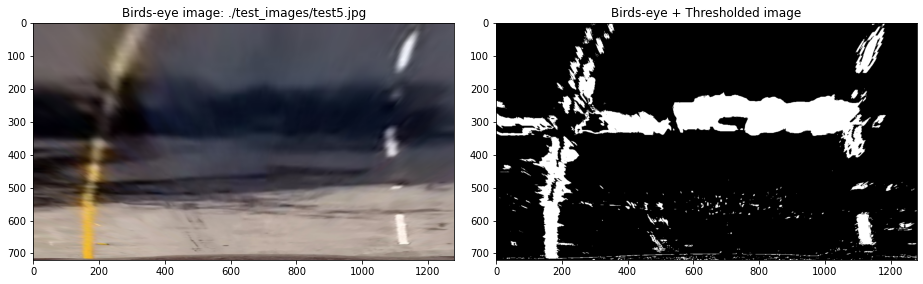

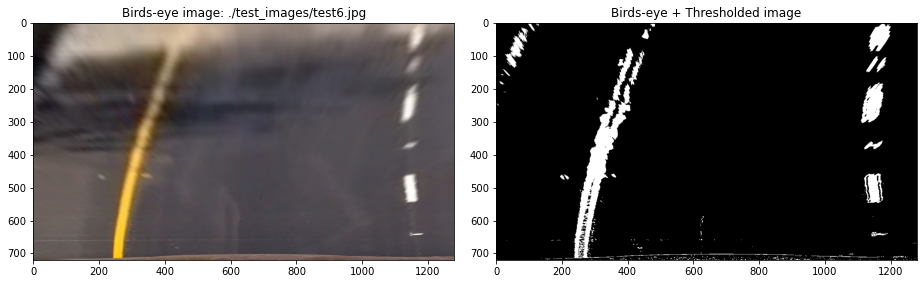

In [2]:
# Transform undistorted images with combined thresholds plus birds-eye combinations
import cv2
import glob
import matplotlib.pyplot as plt
from image_helper import rgb_image, rgb_to_gray, bgr_to_rgb, sorter
from distortion import Distortion
import combined_thresholds
from birdseye import BirdsEyeView

distortion = Distortion("./camera_cal/wide_dist_pickle.p")

images = sorted(glob.glob('./test_images/*.jpg'))

for i, filepath in enumerate(images[:]):
    img = cv2.imread(filepath)

    birdseye = BirdsEyeView()
    img = distortion.undistort(img)
    bev = birdseye.transform_to_birdseye(img)
    thr, _ = combined_thresholds.pipeline(bev)
    
    plt.imsave("./output_images/birdseye_threshold_{:02d}.jpg" .format(i), thr, cmap='gray')
    
    f, (ax1, ax2) = plt.subplots(1, 2, figsize=(13, 10))
    f.tight_layout()
    
    ax1.set_title("Birds-eye image: " +filepath)
    ax1.imshow(bgr_to_rgb(bev))

    ax2.set_title("Birds-eye + Thresholded image")
    ax2.imshow(thr, cmap='gray')

    plt.show()

## 5. Find lane lines

__Source code:__ detect.py, lanes.py, lane.py, bestfit.py

Lane line detection is done using the sliding windows technique. The sum of all the line points detected in the thresholding phase is taken for the bottom half of the image which gives approximate location of where the two lane lines are. Using this approximation, we then find all the nonzero values inside a window, and store those points as points for the lane line. We slide the window up, and repeat finding nonzero values. When the sliding window reaches the top of the image, we fit a parabola to the points that were detected. This polynomial can be used to calculate the lane line values at any point. Shown below are from test_images passed to the **detect_lane_lines()** and **best_fit_lines()** methods with sliding windows and lane lines highlighted plus best-fit lines drawn.

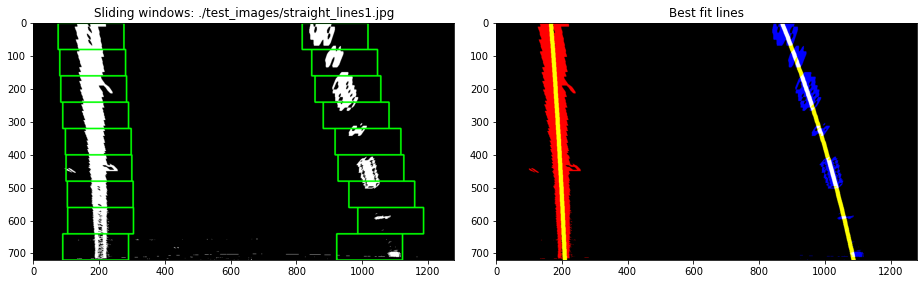

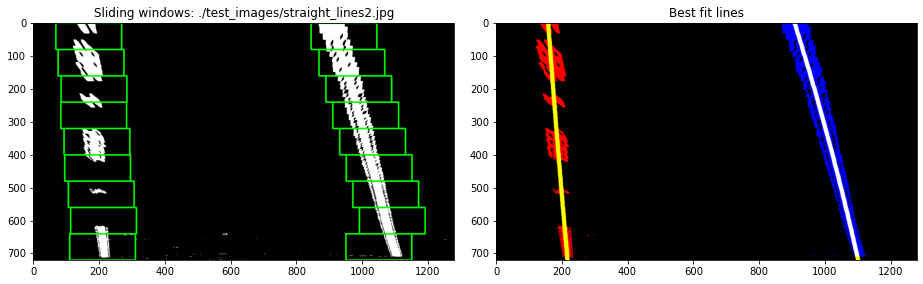

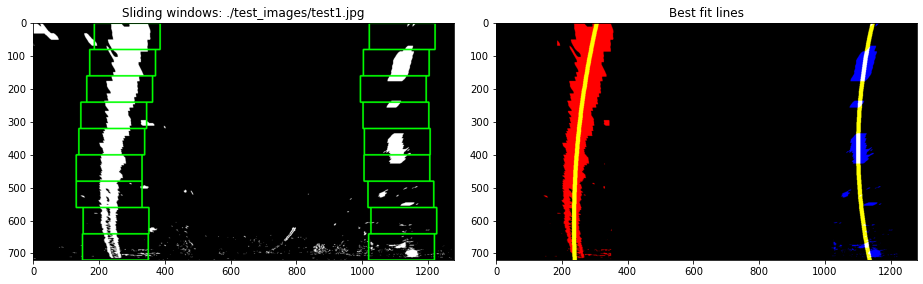

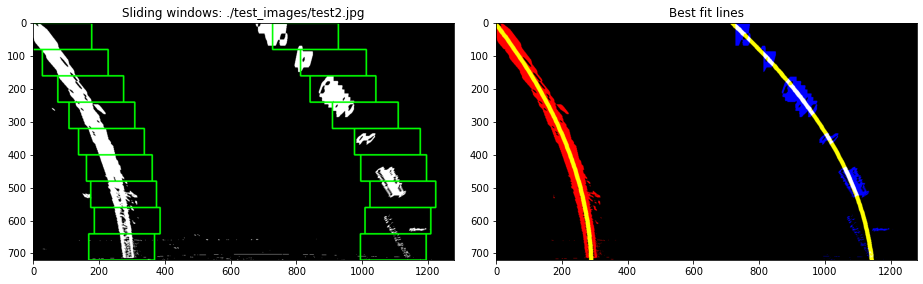

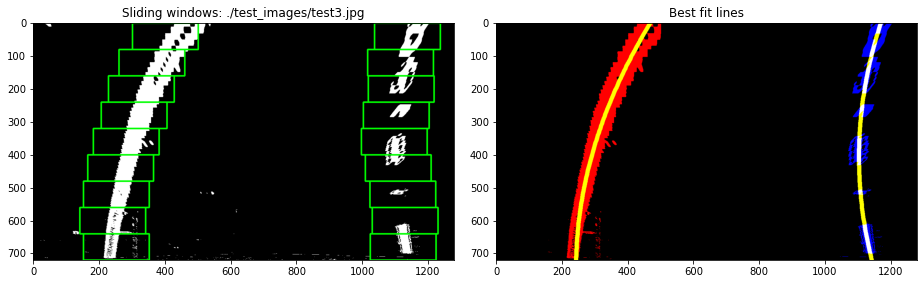

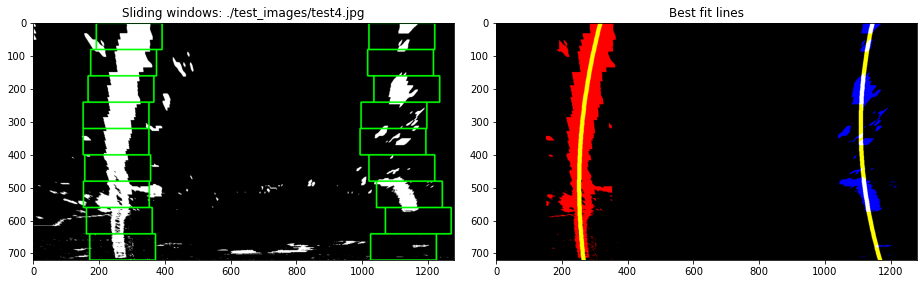

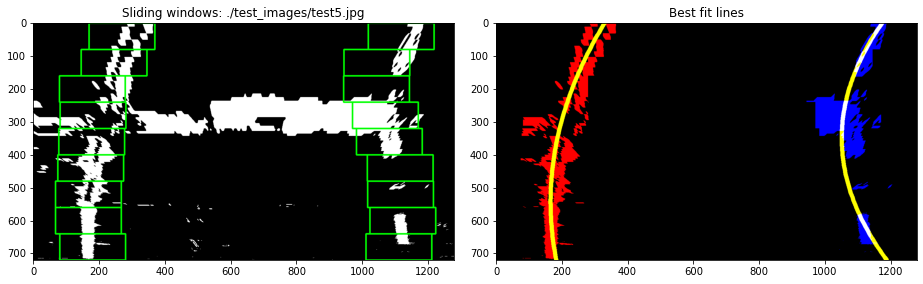

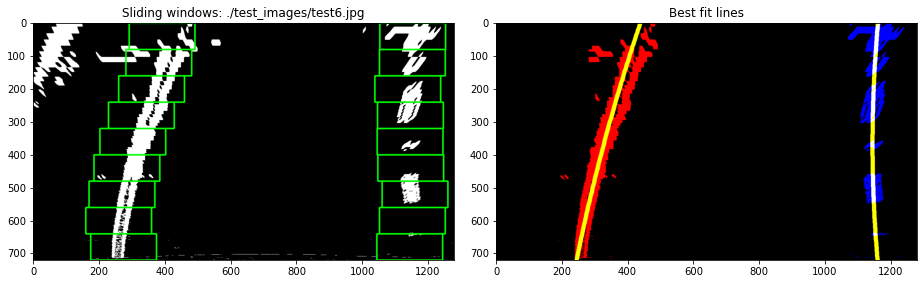

In [3]:
# Fit sliding windows to lane lines and find lines of best fit
import cv2
import glob
import matplotlib.pyplot as plt
from image_helper import rgb_image, sorter
from distortion import Distortion
import combined_thresholds
from birdseye import BirdsEyeView
from detect import detect_lane_lines
from bestfit import best_fit_lines

distortion = Distortion("./camera_cal/wide_dist_pickle.p")
birdseye = BirdsEyeView()

images = sorted(glob.glob('./test_images/*.jpg'))

for i, filepath in enumerate(images[:]):
    img = cv2.imread(filepath)
    undt = distortion.undistort(img)
    thr, _ = combined_thresholds.pipeline(undt)
    bev = birdseye.transform_to_birdseye(thr)
    lanes, win = detect_lane_lines(bev)
    bestfit = best_fit_lines(lanes, win)
    
    plt.imsave("./output_images/windows_{:02d}.jpg" .format(i), win)
    plt.imsave("./output_images/lanes_{:02d}.jpg" .format(i), bestfit)
    
    f, (ax1, ax2) = plt.subplots(1, 2, figsize=(13, 10))
    f.tight_layout()

    ax1.set_title("Sliding windows: " +filepath)
    ax1.imshow(win)

    ax2.set_title("Best fit lines")
    ax2.imshow(bestfit)

    

## 6. Determine lane curvature and vehicle position

__Source code:__ detect.py, lanes.py, lane.py, lanes_average.py 

__Lane curvature__  
Lane curvature is determined using the following curvature formula  

fit = np.polyfit(xs, ys) # using the xs and ys found during detection  
p   = np.poly1d(fit)     # polynomial helper function  
p1  = np.polyder(p)      # first derivative of our polynomial  
p2  = np.polyder(p, 2)   # second derivative of our polynomial  

y is the point at which you'd like to find the curvature   
__((1 + (p1(y)*2))*1.5) / np.absolute(p2(y))__  
These calculations are performed inside lane.py.  

__Vehicle offset position__  
Assuming the camera is mounted in the center of the car, the vehicle offset position can be calculated by measuring the distance from the center of the lane to the center of the image.

Left lane curvature, right lane curvature and vehicle offset position from center are calculated for each test_image.

In [4]:
import cv2
import glob
import matplotlib.pyplot as plt
import locale
from image_helper import rgb_image, sorter
from distortion import Distortion
import combined_thresholds
from birdseye import BirdsEyeView
from detect import detect_lane_lines

distortion = Distortion("./camera_cal/wide_dist_pickle.p")
birdseye = BirdsEyeView()

images = sorted(glob.glob('./test_images/*.jpg'))

for i, filepath in enumerate(images[:]):
    img = cv2.imread(filepath)    
    height, width, _ = img.shape
    
    undt = distortion.undistort(img)
    bev = birdseye.transform_to_birdseye(undt)
    thr, gb = combined_thresholds.pipeline(bev)
    lanes, _ = detect_lane_lines(thr)
    
    left_curvature = lanes.left.meters.curvature(height)
    right_curvature = lanes.right.meters.curvature(height)
    distance_from_center = lanes.distance_from_center(center=(width/2, height))
    
    # Print curvature
    print('Test image: ',filepath)
    print('Left curvature: ',locale.format_string('%.4f', left_curvature, True), 'm')
    print('Right curvature: ',locale.format_string('%.4f', right_curvature, True),'m')
    print('Vehicle offset: ', locale.format_string('%.4f', distance_from_center, True), 'm',"\n")

Test image:  ./test_images/straight_lines1.jpg
Left curvature:  2291.6441 m
Right curvature:  1252.1834 m
Vehicle offset:  0.0367 m 

Test image:  ./test_images/straight_lines2.jpg
Left curvature:  4942.7153 m
Right curvature:  2494.5407 m
Vehicle offset:  0.0989 m 

Test image:  ./test_images/test1.jpg
Left curvature:  800.5452 m
Right curvature:  717.0567 m
Vehicle offset:  0.2342 m 

Test image:  ./test_images/test2.jpg
Left curvature:  316.3850 m
Right curvature:  213.9357 m
Vehicle offset:  0.3545 m 

Test image:  ./test_images/test3.jpg
Left curvature:  524.5260 m
Right curvature:  429.2957 m
Vehicle offset:  0.2710 m 

Test image:  ./test_images/test4.jpg
Left curvature:  559.7443 m
Right curvature:  530.2290 m
Vehicle offset:  0.3927 m 

Test image:  ./test_images/test5.jpg
Left curvature:  291.3414 m
Right curvature:  172.0814 m
Vehicle offset:  0.2359 m 

Test image:  ./test_images/test6.jpg
Left curvature:  616.1206 m
Right curvature:  917.6213 m
Vehicle offset:  0.3603 m 



## 7. Overlay on road

__Source code:__ pipeline.py, overlay.py

**pipeline.py** combines all the steps described above and then calls **overlay.py** to overlay a polygon marking the lane and to overlay text showing the left and right lane line curvatures and vehicle offset position from the centre of the lane. Shown below are final set of test_images with lane overlays.

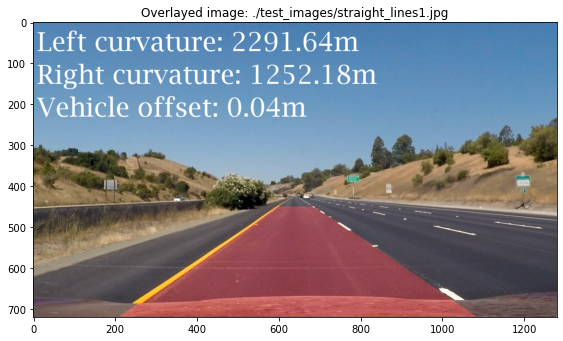

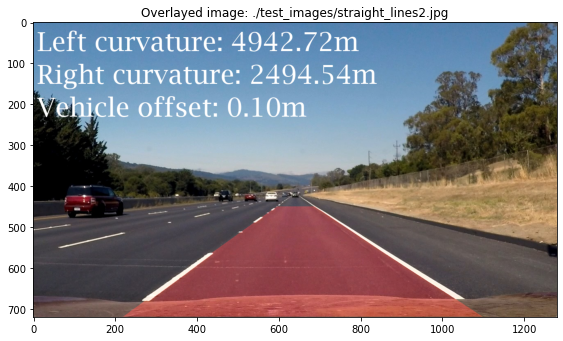

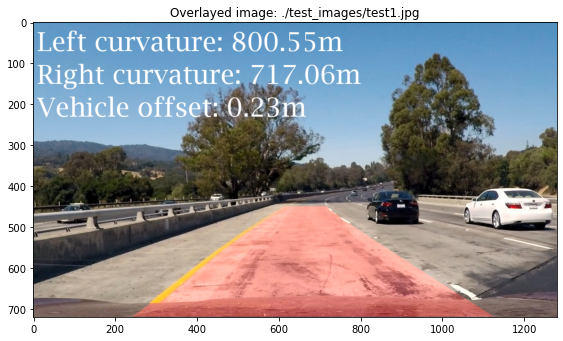

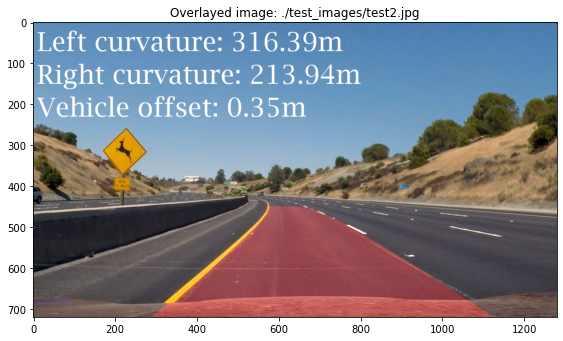

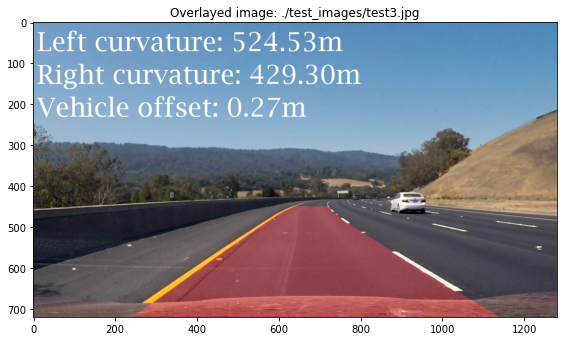

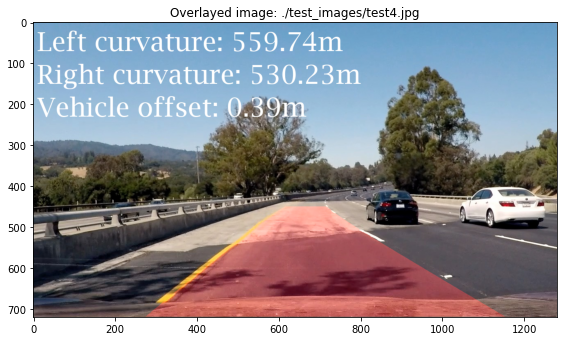

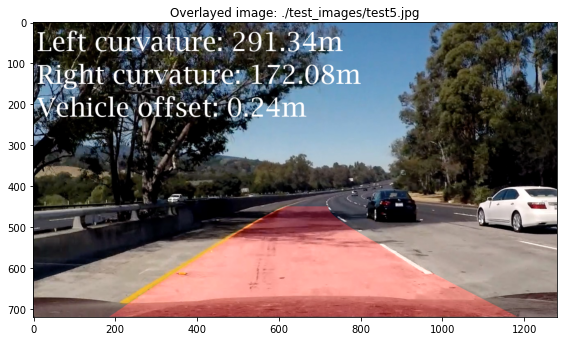

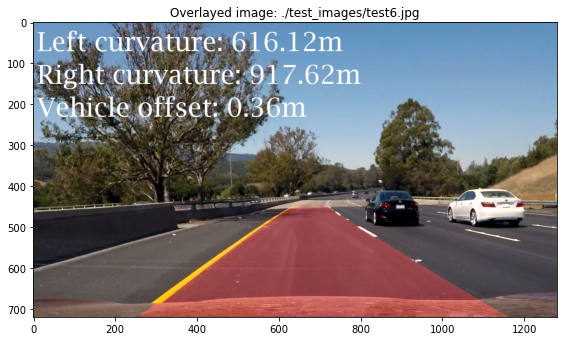

In [5]:
import cv2
import glob
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
from image_helper import rgb_image, bgr_to_rgb, sorter
from pipeline import Pipeline

images = sorted(glob.glob('./test_images/*.jpg'))

def process_image_pipeline(filepath, ax):
    pipeline = Pipeline()
    img = cv2.imread(filepath)
    out = pipeline.process_image_pipeline(img)
    ax.set_title(filepath)
    ax.imshow(out)
    
    return out

for i, filepath in enumerate(images[:]):
    img = cv2.imread(filepath)
    
    f, (ax1) = plt.subplots(1, 1, figsize=(8, 5))
    f.tight_layout()

    pipe_out = process_image_pipeline(filepath, ax1)
    
    plt.imsave("./output_images/final_{:02d}.jpg" .format(i), bgr_to_rgb(pipe_out))
    
    ax1.set_title("Overlayed image: " +filepath)
    ax1.imshow(bgr_to_rgb(pipe_out))
    
    plt.show()

## 8. Pipeline on video

__Source code:__ pipeline.py, process_video.py

Using the MoviePY library, each image in the video is called by **pipeline.process_image_pipeline()** method and then re-combined to produce a new video.

In [ ]:
from moviepy.editor import VideoFileClip
from pipeline import Pipeline
import matplotlib.pyplot as plt

pipeline = Pipeline()

def process_video_pipeline(clip):
    #white_clip = clip.fl_image(pipeline.process_image_pipeline).subclip(0,5) #NOTE: this function expects color images!!
    white_clip = clip.fl_image(pipeline.process_image_pipeline)
    white_clip.write_videofile(video_output, audio=False)
    
clip1 = VideoFileClip('project_video.mp4')
video_output = './output_videos/ALL_project_video.mp4'
#clip2 = VideoFileClip('challenge_video.mp4')
#video_output = './output_videos/ALL_challenge_video.mp4'
#clip3 = VideoFileClip('harder_challenge_video.mp4')
#video_output = './output_videos/ALL_harder_challenge_video.mp4'
    
process_video_pipeline(clip1)
    